This notebook retrieves the static data which will be used as inputs for the forward simulation and data assimilation components. For demonstration purposes, the wildfire incident in this notebook has been taken from CAL FIRE historical records of contained fires with known identifiers and geometries. In a more advanced version, data retrieval would be triggered by fire activity detection via satellites. 

Incident identifiers, coordinates, ignition/containment timestamps: https://data-nifc.opendata.arcgis.com/

Perimeter updates: https://egis.fire.ca.gov/portal/home/index.html

Final perimeters: https://data-nifc.opendata.arcgis.com/datasets/nifc::wfigs-interagency-fire-perimeters/about

Landscape layers: https://lfps.usgs.gov/

In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import geojson
import shapely
from shapely.geometry import Polygon, Point, mapping
import rasterio
from rasterio import plot, mask
from rasterio.plot import show
import zipfile
import time
import io
from PIL import Image
from PIL.TiffTags import TAGS
from osgeo import gdal

The digital twins in this example will use data from two past wildfire incidents in California: the 2025 BORDER 2 fire in San Diego County, and the 2019 MARIA wildfire in Ventura County.

MARIA incident page (CAL FIRE): https://www.fire.ca.gov/incidents/2019/10/31/maria-fire

BORDER 2 incident page (CAL FIRE): https://www.fire.ca.gov/incidents/2025/1/23/border-2-fire

# Ignition data
All ignition coordinates are in EPSG:4326.

In [2]:
### MARIA (2019, Ventura County)

# Name and IRWIN ID
INCIDENT_NAME = "MARIA"
IRWIN_ID = "a62f7cde-ccba-44b9-8f10-eee18946a218"


# Ignition alert and containment timestampes
IGNITION_TIME = "2019-10-31T20:58:00"
CONTAINMENT_TIME = "2019-11-06T18:00:00"


# Ignition coordinates
IGNITION_LAT = 34.302212
IGNITION_LON = -118.997115
IGNITION_POINT = Point((IGNITION_LON, IGNITION_LAT))


# Write incident ignition data to GeoJSON
ignition_feature = geojson.Feature(
    geometry=mapping(IGNITION_POINT),
    properties={
        "incident_name": INCIDENT_NAME,
        "irwin_id": IRWIN_ID,
        "ignition_time": IGNITION_TIME,
        "containment_time": CONTAINMENT_TIME,
    }
)


# FeatureCollection
feature_collection = geojson.FeatureCollection([ignition_feature])


# Write to file
with open("outputs/maria_ignition.geojson", "w") as f:
    geojson.dump(feature_collection, f, indent=2)

In [3]:
### BORDER 2 (2025, San Diego County)

# Name and IRWIN ID
INCIDENT_NAME = "BORDER 2"
IRWIN_ID = "386ebecf-af18-442d-b5d9-e2772b91914a"


# Ignition alert and containment timestamps
IGNITION_TIME = "2025-01-23T13:53:00"
CONTAINMENT_TIME = "2025-01-28T18:00:00"


# Ignition coordinates
IGNITION_LAT = 32.601
IGNITION_LON = -116.841
IGNITION_POINT = Point((IGNITION_LON, IGNITION_LAT))


# Write incident ignition data to GeoJSON
ignition_feature = geojson.Feature(
    geometry=mapping(IGNITION_POINT),
    properties={
        "incident_name": INCIDENT_NAME,
        "irwin_id": IRWIN_ID,
        "ignition_time": IGNITION_TIME,
        "containment_time": CONTAINMENT_TIME,
    }
)


# FeatureCollection
feature_collection = geojson.FeatureCollection([ignition_feature])

# Write to file
with open("outputs/border2_ignition.geojson", "w") as f:
    geojson.dump(feature_collection, f, indent=2)

In [4]:
# TODO EXAMPLE: BRIDGE (2021, Placer County)

# Landscape layers

Static landscape data (3+ years old) is retrieved from the LANDFIRE Product Service (LFPS): https://lfps.usgs.gov/

The following landscape layers are required to run FARSITE, with corresponding LFPS product names:
- Canopy Bulk Density (250CBD)
- Canopy Base Height (250CBH)
- Canopy Cover (250CC)
- Canopy Height (250CH)
- Fire Behavior Fuel Models (250FBFM40)
- Aspect (ASP2020)
- Elevation (ELEV2020)
- Slope Percent Rise (SLPP2020)

LFPS queries require a defined area of interest in EPSG:4326 and with an area of at minimum 900 m$^2$. For the example incidents in this notebook, the areas of interest will be defined by a 10-mile bounding box [min longitude, min latitude, max longitude, max latitude] around the ignition coordinate point.

In [5]:
# Calculate and save Area of Interest
radius_miles = 10
radius_meters = radius_miles * 1609.344


# Ignition point in lon/lat and projected to UTM zone
pt = gpd.GeoSeries([IGNITION_POINT], crs="EPSG:4326")
pt_utm = pt.to_crs(pt.estimate_utm_crs())


# Buffer and get bounding box in projected CRS
buffer_utm = pt_utm.buffer(radius_meters)
minx, miny, maxx, maxy = buffer_utm.total_bounds


# Convert bbox corners back to lon/lat
corners_utm = gpd.GeoSeries(
    [Point(minx, miny), Point(maxx, maxy)],
    crs=pt_utm.crs
).to_crs("EPSG:4326")


min_lon, min_lat = corners_utm.iloc[0].x, corners_utm.iloc[0].y
max_lon, max_lat = corners_utm.iloc[1].x, corners_utm.iloc[1].y


# Build bbox polygon (GeoJSON order: lon, lat)
bbox_polygon = Polygon([
    (min_lon, min_lat),
    (max_lon, min_lat),
    (max_lon, max_lat),
    (min_lon, max_lat),
    (min_lon, min_lat),
])


# Create GeoJSON Feature
bbox_feature = geojson.Feature(
    geometry=bbox_polygon,
    properties={
        "type": "bounding_box",
        "radius_miles": radius_miles,
        "center_lon": IGNITION_LON,
        "center_lat": IGNITION_LAT,
    }
)

# Write to GeoJSON file
fc = geojson.FeatureCollection([bbox_feature])
with open("outputs/border2_polygon.geojson", "w") as f:
    geojson.dump(fc, f, indent=2)

bbox_feature

{"geometry": {"coordinates": [[[-117.012489, 32.45592], [-116.668957, 32.45592], [-116.668957, 32.74584], [-117.012489, 32.74584], [-117.012489, 32.45592]]], "type": "Polygon"}, "properties": {"center_lat": 32.601, "center_lon": -116.841, "radius_miles": 10, "type": "bounding_box"}, "type": "Feature"}

In [6]:
# Submit job request for landscape data to LFPS API
LFPS_URL = "https://lfps.usgs.gov/api/job/submit?"


# Required parameters
email = "h7ahmed@ucsd.edu"  # Replace with your email address
layer_list = "250CBD;250CBH;250CC;250CH;250FBFM40;ASP2020;ELEV2020;SLPP2020"
area_of_interest = f"{min_lon} {min_lat} {max_lon} {max_lat}"
output_projection = "5070"


# Default values for optional parameters
resample_resolution =  "90"
priority_code = "K3LS9F"


# Construct request URL
LFPS_PARAMS = {
    "Email": email,
    "Layer_List": layer_list,
    "Area_of_Interest": area_of_interest,
    "Output_Projection": output_projection,
    "Resample_Resolution":resample_resolution,
    "Priority_Code": priority_code
}


# Submit job to LFPS
LFPS_RESPONSE = requests.get(LFPS_URL, LFPS_PARAMS)


# Track job status
JOB_ID = LFPS_RESPONSE.json()["jobId"]
LFPS_STATUS_URL = f"https://lfps.usgs.gov/api/job/status?JobId={JOB_ID}"
while True:
    status_response = requests.get(LFPS_STATUS_URL, timeout=30).json()
    status = status_response.get("status", "").lower()
    print("Status:", status)
    if status in ("succeeded", "failed", "canceled"):
        result = status_response
        break
    time.sleep(5)

Status: pending
Status: executing
Status: executing
Status: executing
Status: succeeded


In [7]:
# Get output file from LFPS response

if status != "succeeded":  # Error if failed
    raise RuntimeError(f"LFPS job failed.")
    
else:  # Extract landscape files
    LFPS_OUTPUT_URL = status_response["outputFile"]
    LFPS_OUTPUT_ZIP =  requests.get(LFPS_OUTPUT_URL, stream=True)
    
    LANDSCAPE_DIR = "landscape"
    os.makedirs(LANDSCAPE_DIR, exist_ok=True)  # Create directory if not exists
    print("Created landscape directory.")
    
    with zipfile.ZipFile(io.BytesIO(LFPS_OUTPUT_ZIP.content)) as zf:
        zf.extractall(LANDSCAPE_DIR)
        print("Extracted landscape output files")

        # Write corresponding projection files
        for fname in os.listdir(LANDSCAPE_DIR):
            if fname.lower().endswith(".tif"):
                GEOTIFF_FILEPATH = os.path.join(LANDSCAPE_DIR, fname)
                break
        
        # Get CRS 5070 projection in Well-Known Text (WKT) format
        WKT_5070_URL = "https://epsg.io/5070-1252.wkt"
        WKT_5070_RESPONSE = requests.get(WKT_5070_URL)
        PROJ_5070_TEXT = WKT_5070_RESPONSE.text
        
        # Create .prj projection file corresponding to .tif landscape file
        PRJ_FILEPATH = os.path.splitext(GEOTIFF_FILEPATH)[0] + ".prj"
        with open(PRJ_FILEPATH, "w") as f:
            f.write(PROJ_5070_TEXT)

        print("Wrote projection file for EPSG 5070.")

Created landscape directory.
Extracted landscape output files
Wrote projection file for EPSG 5070.


In [8]:
### Extract landscape raster bands from LFPS file output

band_names = ["250CBD", "250CBH", "250CC", "250CH", "250FBFM40", "ASP2020", "ELEV2020", "SLPP2020"]
ascii_files = {}

with rasterio.open(GEOTIFF_FILEPATH) as src:
    profile = src.profile

    # Extract each band to GeoTIFF with corresponding ASCII and PRJ files.
    for i in range(1, src.count + 1):
        band_name = band_names[i-1]
        band_data = src.read(i)

        band_profile = profile.copy()
        band_profile.update(count=1)

        
        # Extract raster band to GeoTIFF file.
        band_filepath = os.path.join(LANDSCAPE_DIR, f"{band_name}.tif")
        with rasterio.open(band_filepath, "w", **band_profile) as dst:
            dst.write(band_data, 1)
        print(f"Created {band_filepath}.")

        
        # Create corresponding ASCII file.
        ascii_filepath = os.path.join(LANDSCAPE_DIR, f"{band_name}.asc")
        ascii_files[band_name] = ascii_filepath

        with rasterio.open(band_filepath) as bsrc:
            b = bsrc.bounds
            projwin = [b.left, b.top, b.right, b.bottom]

        gdal.Translate(
            ascii_filepath,
            band_filepath,
            format="AAIGrid",
            projWin=projwin,
            noData=-32768,
        )
        print(f"Created {ascii_filepath}.")

        
        # Write corresponding projection file
        prj_filepath = os.path.join(LANDSCAPE_DIR, f"{band_name}.prj")
        with open(prj_filepath, "w") as f:
            f.write(PROJ_5070_TEXT)
        print(f"Created {prj_filepath}.")

Created landscape/250CBD.tif.


/opt/conda/lib/python3.12/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


Created landscape/250CBD.asc.
Created landscape/250CBD.prj.
Created landscape/250CBH.tif.


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


Created landscape/250CBH.asc.
Created landscape/250CBH.prj.
Created landscape/250CC.tif.


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


Created landscape/250CC.asc.
Created landscape/250CC.prj.
Created landscape/250CH.tif.


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


Created landscape/250CH.asc.
Created landscape/250CH.prj.
Created landscape/250FBFM40.tif.


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


Created landscape/250FBFM40.asc.
Created landscape/250FBFM40.prj.
Created landscape/ASP2020.tif.


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


Created landscape/ASP2020.asc.
Created landscape/ASP2020.prj.
Created landscape/ELEV2020.tif.


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


Created landscape/ELEV2020.asc.
Created landscape/ELEV2020.prj.
Created landscape/SLPP2020.tif.


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


Created landscape/SLPP2020.asc.
Created landscape/SLPP2020.prj.


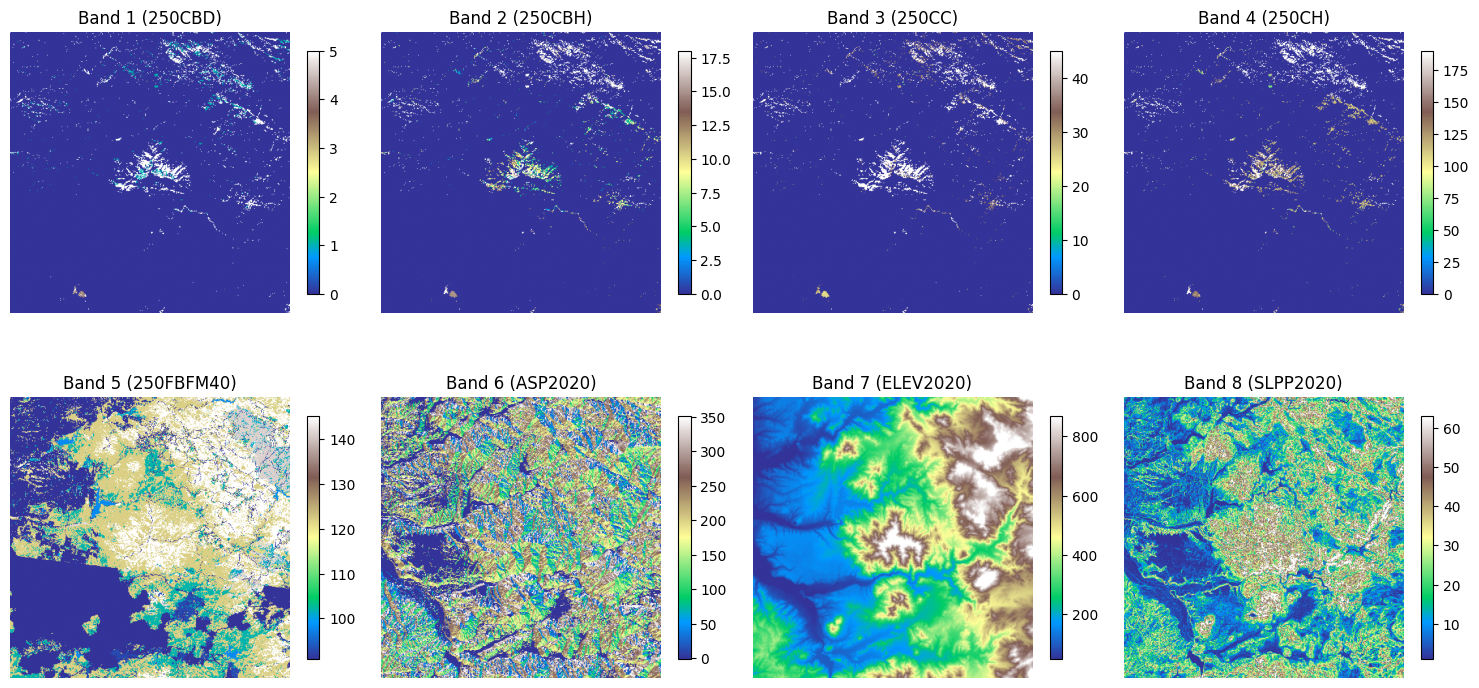

In [9]:
### Plot landscape raster bands in area of interest (VNc unit)

with rasterio.open(GEOTIFF_FILEPATH) as src:
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    
    for i in range(1, src.count + 1):
        ax = axes[(i-1)//4, (i-1)%4]
        band = src.read(i).astype(float)
        band[band == src.nodata] = np.nan  # mask NoData

        # Plot on color map
        cmap = "terrain"
        vmin, vmax = np.nanpercentile(band, 2), np.nanpercentile(band, 98)

        im = ax.imshow(band, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f"Band {i} ({band_names[i-1]})")
        ax.axis("off")
        plt.colorbar(im, ax=ax, shrink=0.6)
    
    plt.tight_layout()
    plt.show()


## Creating the LCP file for FARSITE input

In [10]:
LCPMAKE_PATH = "./lcpmake"  # Executable to generate landscape input file for FARSITE
LCPPATH = "landscape"

# Landscape layer flags
landscape_flags = {
    "ELEV2020": "-elevation",
    "SLPP2020": "-slope",
    "ASP2020": "-aspect",
    "250FBFM40": "-fuel",
    "250CC": "-cover",
    "250CH": "-height",
    "250CBH": "-base",
    "250CBD": "-density",
}


# Build the lcpmake command
cmd = [
    LCPMAKE_PATH,
    "-latitude", str(IGNITION_LAT),
    "-landscape", LCPPATH,
]


# Append landscape layer flags to command
for name, ascii_path in ascii_files.items():
    cmd.append(landscape_flags[name])
    cmd.append(ascii_path)
    print(name, ascii_path)

# Fuel model set flag
cmd.append("-fb40")

250CBD landscape/250CBD.asc
250CBH landscape/250CBH.asc
250CC landscape/250CC.asc
250CH landscape/250CH.asc
250FBFM40 landscape/250FBFM40.asc
ASP2020 landscape/ASP2020.asc
ELEV2020 landscape/ELEV2020.asc
SLPP2020 landscape/SLPP2020.asc


In [11]:
# Run lcpmake command to generate LCP file
print("\nRunning lcpmake command:")
print(" ".join(cmd), "\n") # print comand 
os.system(" ".join(cmd))

# Save CRS projection file corresponding to landscape.lcp
with open(os.path.join("landscape.prj"), "w") as f:
    f.write(PROJ_5070_TEXT)


Running lcpmake command:
./lcpmake -latitude 32.601 -landscape landscape -density landscape/250CBD.asc -base landscape/250CBH.asc -cover landscape/250CC.asc -height landscape/250CH.asc -fuel landscape/250FBFM40.asc -aspect landscape/ASP2020.asc -elevation landscape/ELEV2020.asc -slope landscape/SLPP2020.asc -fb40 

-----------------------------------
-----------------------------------

LCPMake processing grid themes.....

-----------------------------------
-----------------------------------

Size of header data:7316


LCPMAKE.EXE Completed......

Landscape File Generated:

>>>>  landscape.lcp


